1) Imports & chargement du dataset fusionné

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")

DATA_PATH = Path("..") / "data" / "clean_data" / "location_all_sources.csv"
assert DATA_PATH.exists(), "❌ Dataset fusionné introuvable"

df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")

print("Shape:", df.shape)
df.head()


Shape: (15856, 9)


,ville,prix,surface,quartier,type_bien,nb_chambres,nb_salle_de_bain,url_annonce,source
0,Casablanca,20000.0,48.0,Maarif,Appartement,5,1,https://www.avito.ma/fr/maarif/appartements/__...,Avito
1,Tanger,6500.0,90.0,Castilla,Appartement,4,1,https://www.avito.ma/fr/castilla/appartements/...,Avito
2,Casablanca,17000.0,155.0,Racine,Appartement,3,1,https://www.avito.ma/fr/racine/appartements/CM...,Avito
3,Casablanca,2300.0,56.0,Oulfa,Appartement,3,1,https://www.avito.ma/fr/oulfa/appartements/App...,Avito
4,Casablanca,5500.0,90.0,Route d'Azemmour,Appartement,3,1,https://www.avito.ma/fr/route_d_azemmour/appar...,Avito


In [11]:
# =========================
# Normalisation des noms de villes (multi-langue)
# =========================

def normalize_city(v):
    if pd.isna(v):
        return None

    v = str(v).strip().lower()

    mapping = {
        # Casablanca
        "casablanca": "Casablanca",
        "casa": "Casablanca",
        "الدار البيضاء": "Casablanca",

        # Rabat
        "rabat": "Rabat",
        "الرباط": "Rabat",

        # Marrakech
        "marrakech": "Marrakech",
        "marrakesh": "Marrakech",
        "مراكش": "Marrakech",

        # Tanger
        "tanger": "Tanger",
        "tangier": "Tanger",
        "طنجة": "Tanger",
    }

    return mapping.get(v, v.title())

# Application
df["ville"] = df["ville"].apply(normalize_city)


In [12]:
df["ville"].value_counts()


ville
Casablanca    8355
Marrakech     3322
Rabat         2238
Tanger        1941
Name: count, dtype: int64

2) Vérification des sources

In [13]:
df["source"].value_counts()


source
Avito      12835
Mubawab     3021
Name: count, dtype: int64

Les annonces proviennent majoritairement de deux plateformes : Avito et Mubawab, avec des volumes comparables / différents selon la période de collecte.

3) Distribution des prix par source

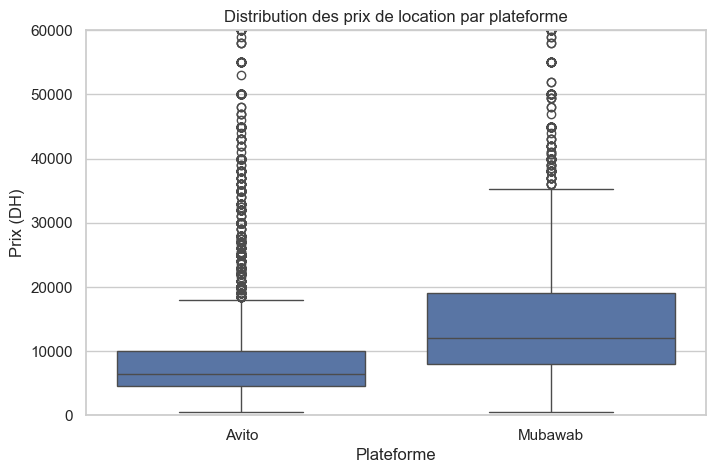

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="source", y="prix")
plt.title("Distribution des prix de location par plateforme")
plt.ylabel("Prix (DH)")
plt.xlabel("Plateforme")
plt.ylim(0, 60000)  # limite visuelle (optionnelle)
plt.show()


4) Prix moyen & médian par source

In [15]:
df.groupby("source")["prix"].agg(["mean", "median", "std", "count"])


,mean,median,std,count
source,,,,
Avito,8732.153757,6500.0,7715.674698,12835
Mubawab,15821.367759,12000.0,12614.212557,3021


5) Prix au m² par source

In [16]:
df["prix_m2"] = df["prix"] / df["surface"]

df.groupby("source")["prix_m2"].mean()


source
Avito       87.177276
Mubawab    110.623331
Name: prix_m2, dtype: float64

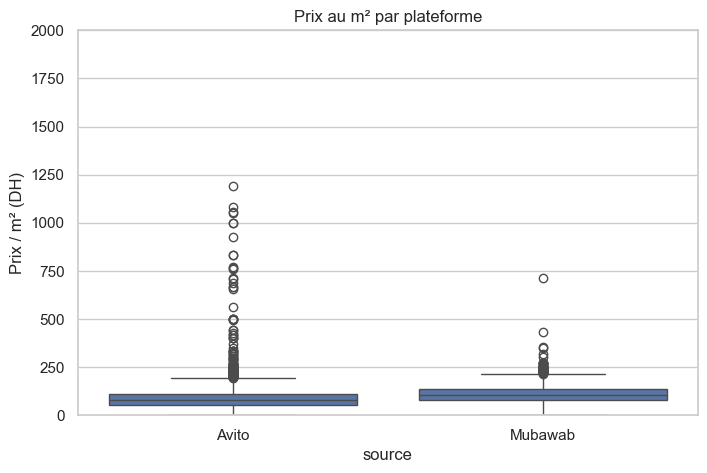

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="source", y="prix_m2")
plt.title("Prix au m² par plateforme")
plt.ylabel("Prix / m² (DH)")
plt.ylim(0, 2000)
plt.show()


Le prix au m² est globalement plus élevé sur Mubawab, indiquant une meilleure valorisation des biens ou une sélection différente des annonces.

6) Répartition des types de biens par source

In [18]:
pd.crosstab(df["type_bien"], df["source"], normalize="columns") * 100


source,Avito,Mubawab
type_bien,,
Appartement,78.176860,84.111221
Maison,14.990261,0.695134
Riad,0.000000,0.066203
Villa,6.832879,15.127441


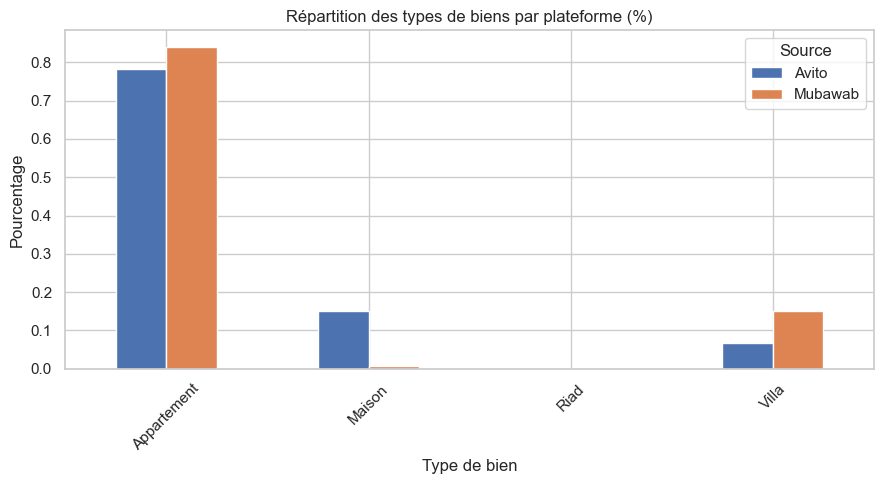

In [19]:
pd.crosstab(df["type_bien"], df["source"], normalize="columns").plot(
    kind="bar", figsize=(9,5)
)
plt.title("Répartition des types de biens par plateforme (%)")
plt.ylabel("Pourcentage")
plt.xlabel("Type de bien")
plt.legend(title="Source")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Avito est davantage orienté vers les appartements standards, tandis que Mubawab propose proportionnellement plus de biens haut de gamme (villas, studios premium).

7) Analyse par ville (comparative)

In [20]:
df.groupby(["ville", "source"])["prix"].median().unstack()


source,Avito,Mubawab
ville,,
Casablanca,6300.0,10000.0
Marrakech,7000.0,12000.0
Rabat,11000.0,18000.0
Tanger,5000.0,10000.0


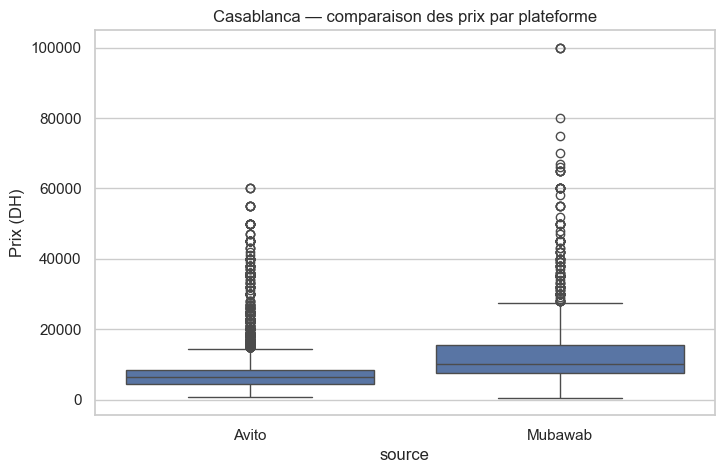

In [21]:
casablanca = df[df["ville"] == "Casablanca"]

plt.figure(figsize=(8,5))
sns.boxplot(data=casablanca, x="source", y="prix")
plt.title("Casablanca — comparaison des prix par plateforme")
plt.ylabel("Prix (DH)")
plt.show()


Les écarts entre plateformes sont plus marqués dans les grandes villes comme Casablanca, où Mubawab affiche des loyers plus élevés.